In [1]:
import numpy as np
import matplotlib  as mpl
import matplotlib.pyplot as plt

from sklearn.datasets import fetch_openml
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, label_binarize
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_predict, train_test_split
from sklearn.metrics import classification_report, roc_curve
from sklearn.metrics import confusion_matrix, auc, average_precision_score
from sklearn.metrics import roc_auc_score, precision_recall_curve
from sklearn.pipeline import make_pipeline

mnist=fetch_openml('mnist_784',version=1)

In [2]:
print('X shape:',mnist['data'].shape)
print('y shape:',mnist['target'].shape)

X shape: (70000, 784)
y shape: (70000,)


In [3]:
mnist['data'].head()

,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
mnist['target']

0        5
1        0
2        4
3        1
4        9
        ..
69995    2
69996    3
69997    4
69998    5
69999    6
Name: class, Length: 70000, dtype: category
Categories (10, object): ['0', '1', '2', '3', ..., '6', '7', '8', '9']

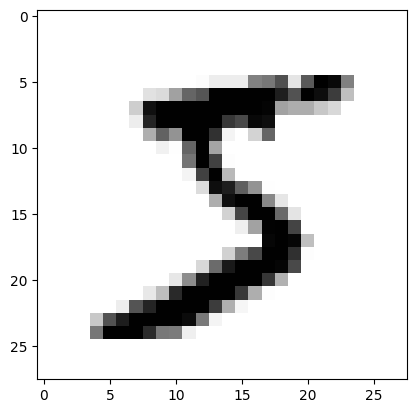

In [5]:
some_digit=np.array(mnist['data'].iloc[0])
some_digit_image=some_digit.reshape(28,28)

plt.imshow(some_digit_image,cmap=mpl.cm.binary,interpolation='nearest')

In [6]:
X = mnist['data'].values
y = mnist['target'].astype(np.uint8).values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=10000, stratify=y, random_state=42)

pipe = make_pipeline(
    StandardScaler(), 
    RandomForestClassifier(n_estimators=200, n_jobs=-1, random_state=42)
)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
proba_cv = cross_val_predict(pipe, X_train, y_train, cv=cv, method='predict_proba', n_jobs=-1)

In [7]:
print("proba_cv shape (n_train_samples, n_classes):", proba_cv.shape)
y_pred_cv = np.argmax(proba_cv, axis=1)

proba_cv shape (n_train_samples, n_classes): (60000, 10)


In [8]:
print('Classification report')
report=classification_report(y_train,y_pred_cv,digits=3)
print(report)

Classification report
              precision    recall  f1-score   support

           0      0.980     0.987     0.983      5917
           1      0.984     0.985     0.985      6752
           2      0.958     0.969     0.963      5991
           3      0.961     0.955     0.958      6121
           4      0.970     0.972     0.971      5849
           5      0.969     0.961     0.965      5411
           6      0.976     0.983     0.979      5894
           7      0.974     0.968     0.971      6251
           8      0.959     0.952     0.956      5850
           9      0.953     0.951     0.952      5964

    accuracy                          0.969     60000
   macro avg      0.968     0.968     0.968     60000
weighted avg      0.969     0.969     0.969     60000



In [9]:
print('Confusion Matrix')
conf_mtx=confusion_matrix(y_train,y_pred_cv)
conf_mtx

Confusion Matrix


array([[5840,    0,    7,    2,    3,    9,   20,    2,   32,    2],
       [   1, 6653,   32,   14,   14,    6,    4,   12,   10,    6],
       [  23,   10, 5804,   31,   23,    2,   20,   38,   34,    6],
       [   7,    6,   77, 5846,    2,   57,    3,   42,   52,   29],
       [  10,    8,    9,    0, 5683,    0,   29,    8,   13,   89],
       [  19,    5,   11,   63,   11, 5202,   39,    6,   34,   21],
       [  21,   13,    5,    0,    8,   38, 5792,    0,   17,    0],
       [   6,   22,   64,    3,   28,    1,    0, 6054,   10,   63],
       [   8,   30,   36,   49,   24,   37,   25,    7, 5570,   64],
       [  25,   11,   12,   75,   62,   18,    4,   48,   35, 5674]])

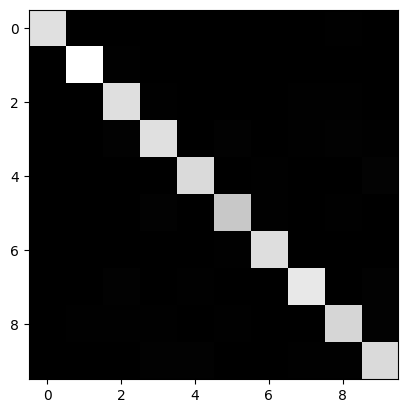

In [10]:
plt.imshow(conf_mtx,cmap=plt.cm.gray)

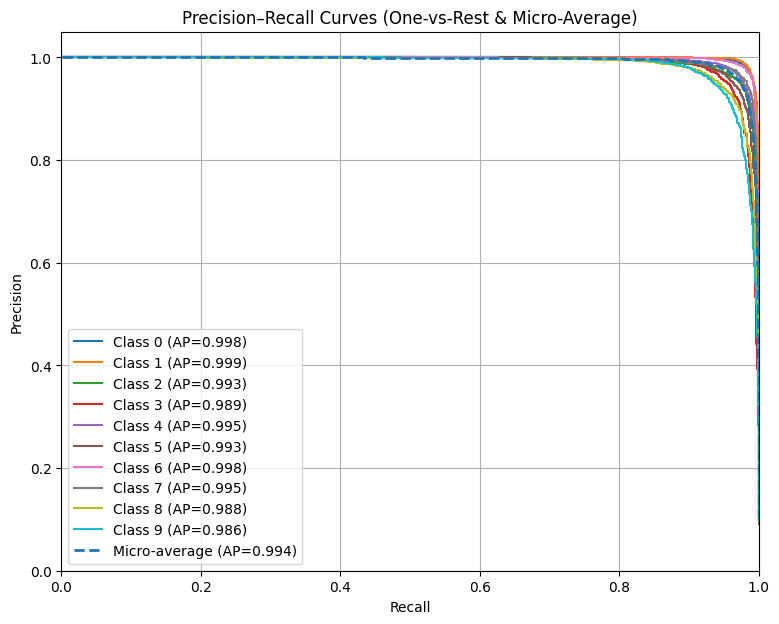

In [11]:
classes = np.unique(y_train)
y_bin = label_binarize(y_train, classes=classes)

plt.figure(figsize=(9, 7))

for i, cls in enumerate(classes):
    y_true_i = y_bin[:, i]
    y_score_i = proba_cv[:, i]

    precision, recall, thresholds = precision_recall_curve(y_true_i, y_score_i)
    ap = average_precision_score(y_true_i, y_score_i)

    plt.step(recall, precision, where="post",
             label=f"Class {cls} (AP={ap:.3f})")

precision_micro, recall_micro, _ = precision_recall_curve(
    y_bin.ravel(), proba_cv.ravel()
)
ap_micro = average_precision_score(y_bin, proba_cv, average='micro')

plt.step(recall_micro, precision_micro, where="post",
         label=f"Micro-average (AP={ap_micro:.3f})", linewidth=2, linestyle="--")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curves (One-vs-Rest & Micro-Average)")
plt.legend(loc="best")
plt.grid(True)
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.show()


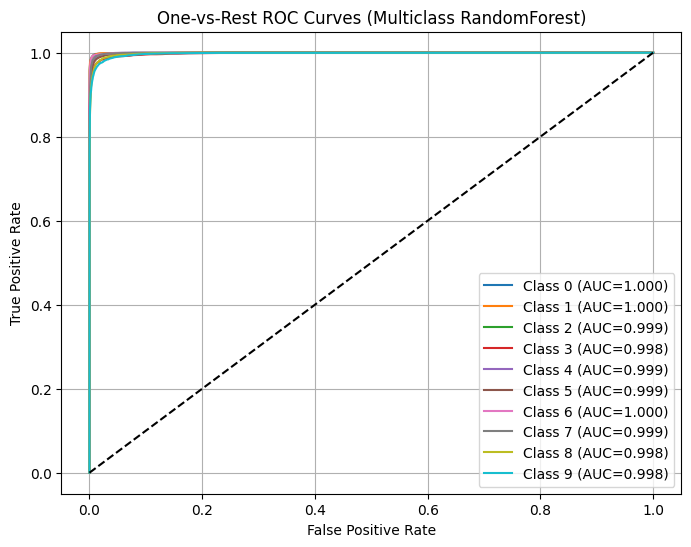

In [12]:
plt.figure(figsize=(8, 6))

for i, cls in enumerate(classes):
    fpr, tpr, _ = roc_curve(y_bin[:, i], proba_cv[:, i])
    auc_score = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"Class {cls} (AUC={auc_score:.3f})")

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("One-vs-Rest ROC Curves (Multiclass RandomForest)")
plt.legend()
plt.grid(True)
plt.show()

In [13]:
pipe.fit(X_train,y_train)
tst_pred=pipe.predict(X_test)
tst_proba = pipe.predict_proba(X_test)

In [14]:
print('Classification report ')
report=classification_report(y_test,tst_pred, digits=3)
print(report)

Classification report 
              precision    recall  f1-score   support

           0      0.974     0.989     0.981       986
           1      0.985     0.988     0.986      1125
           2      0.968     0.969     0.968       999
           3      0.962     0.958     0.960      1020
           4      0.973     0.965     0.969       975
           5      0.974     0.958     0.966       902
           6      0.973     0.984     0.978       982
           7      0.974     0.967     0.971      1042
           8      0.960     0.957     0.958       975
           9      0.938     0.945     0.941       994

    accuracy                          0.968     10000
   macro avg      0.968     0.968     0.968     10000
weighted avg      0.968     0.968     0.968     10000



In [15]:
print('Confusion Matrix')
conf_mtx=confusion_matrix(y_test,tst_pred)
conf_mtx

Confusion Matrix


array([[ 975,    1,    1,    0,    1,    0,    5,    0,    3,    0],
       [   0, 1111,    4,    3,    1,    1,    2,    2,    1,    0],
       [   5,    2,  968,    4,    4,    1,    2,    7,    5,    1],
       [   1,    0,   12,  977,    0,    8,    1,   10,    9,    2],
       [   1,    0,    1,    0,  941,    0,    5,    0,    1,   26],
       [   4,    0,    2,   11,    1,  864,    8,    2,    5,    5],
       [   7,    0,    0,    0,    2,    3,  966,    0,    4,    0],
       [   2,    4,    9,    0,    4,    0,    0, 1008,    2,   13],
       [   2,    4,    2,    6,    1,    8,    4,    0,  933,   15],
       [   4,    6,    1,   15,   12,    2,    0,    6,    9,  939]])

In [16]:
classes = pipe.named_steps['randomforestclassifier'].classes_
y_test_bin = label_binarize(y_test, classes=classes)

auc_micro = roc_auc_score(y_test_bin, tst_proba, average='micro')
auc_macro = roc_auc_score(y_test_bin, tst_proba, average='macro')
print("Micro-average AUC:", auc_micro)
print("Macro-average AUC:", auc_macro)


Micro-average AUC: 0.9992070844444444
Macro-average AUC: 0.9991244982060966


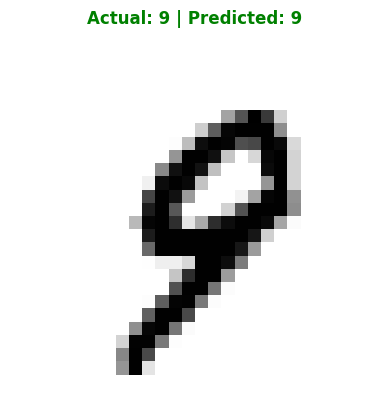

Actual: 9, Predicted: 9
CORRECT ✓


In [17]:
index = 589

sample = mnist['data'].iloc[index]
prediction = pipe.predict([sample])[0]
actual = mnist['target'].iloc[index]

digit_image = np.array(sample).reshape(28, 28)
plt.imshow(digit_image, cmap=mpl.cm.binary, interpolation='nearest')
plt.axis('off')

color = 'green' if str(prediction) == str(actual) else 'red'
plt.title(f'Actual: {actual} | Predicted: {prediction}', color=color, fontweight='bold')
plt.show()

print(f"Actual: {actual}, Predicted: {prediction}")
print("CORRECT ✓" if str(prediction) == str(actual) else "WRONG ✗")